<a href="https://colab.research.google.com/github/jenelaineDC/Natural-Language-Processing/blob/main/Count_Vectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Text Classification BBC Dataset

This notebook demonstrates **text preprocessing techniques** such as **lemmatization** and **stemming**, and compares their effects on model performance using a Naive Bayes classifier.

We'll use the BBC news dataset from LazyProgrammer’s NLP course.

In [1]:

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

# Download required NLTK data
nltk.download("wordnet")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load the BBC Dataset

In [2]:
# Download dataset from LazyProgrammer's website
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

# Load into pandas DataFrame
df = pd.read_csv('bbc_text_cls.csv')
print(df.head())
print("Number of samples:", len(df))


File ‘bbc_text_cls.csv’ already there; not retrieving.

                                                text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business
Number of samples: 2225


## Visualize the Label Distribution

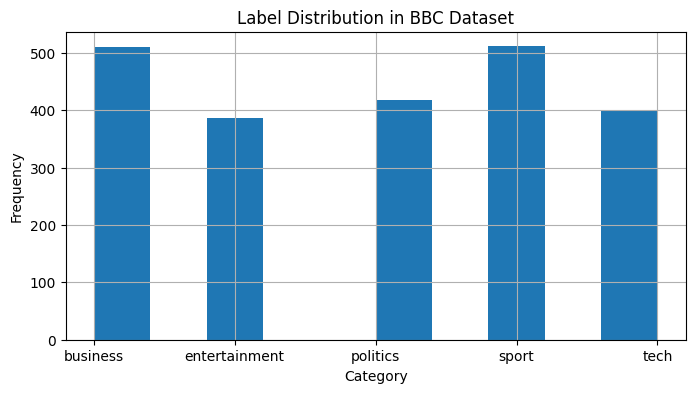

In [3]:

import matplotlib.pyplot as plt

df['labels'].hist(figsize=(8, 4))
plt.title("Label Distribution in BBC Dataset")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.show()


##  Train-Test Split

In [4]:

inputs = df['text']
labels = df['labels']

inputs_train, inputs_test, Ytrain, Ytest = train_test_split(
    inputs, labels, random_state=123)


## Baseline Model

### CountVectorizer()

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

`CountVectorizer` converts a collection of text documents into a matrix of token counts (bag-of-words representation).

Think of it like this:

Text → Words → Count of each word → Numeric vector

**Key Parameters:**

| **Parameter**   | **Description**                                                 | **Default / Example**                    |
| --------------- | --------------------------------------------------------------- | ---------------------------------------- |
| `strip_accents` | Remove accents/diacritics                                       | `None`, `'ascii'`, `'unicode'`           |
| `lowercase`     | Convert all text to lowercase before tokenizing                 | `True`                                   |                                 |
| `tokenizer`     | Custom function to tokenize text                                | `None`                                   |
| `stop_words`    | Remove common words                                             | `None`, `'english'` or list of words     |                          |                                  |
| `max_features`  | Keep only top N most frequent tokens                            | `None` (keep all)                        |


### MultinomialNB()

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

`MultinomialNB` class in Scikit-learn is a Naive Bayes classifier designed for discrete data, often used in text classification tasks like spam detection or sentiment analysis. It assumes that features (e.g., word counts) follow a multinomial distribution.

In [5]:

vectorizer = CountVectorizer()
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

density = (Xtrain != 0).sum() / np.prod(Xtrain.shape)
print(f"Non-zero value percentage: {density:.4f}")


train score: 0.9922062350119905
test score: 0.9712746858168761
Non-zero value percentage: 0.0077


## Model with Stopwords Removed

In [6]:

vectorizer = CountVectorizer(stop_words='english')
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))


train score: 0.9928057553956835
test score: 0.9766606822262118


## Lemmatization and POS Tagging

### Helper Function: POS Tag to WordNet Mapping

**Why this function?**
- NLTK’s `pos_tag()` returns Treebank tags (like NN, VB, JJ).
- But the `WordNetLemmatizer` expects WordNet POS tags (wordnet.NOUN, wordnet.VERB, etc.).
- This helper function converts between the two tagging systems.

Example:
`"running"` → NLTK tag = `VBG` (verb gerund) → mapped to `wordnet.VERB`.

In [7]:

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


### Lemmatization Tokenizer

[WordNetLammatizer Documentation](https://www.nltk.org/api/nltk.stem.wordnet.html#nltk.stem.wordnet.WordNetLemmatizer)

**What’s happening:**

1. `__init__`: creates an instance of NLTK’s `WordNetLemmatizer`.
2. `__call__`: allows the object to act like a function.
  - Tokenizes the text into words.
  - POS-tags each word (`nltk.pos_tag`).
  - Lemmatizes each word using its correct POS.

Example transformation:
```
"Cats are running faster" →
tokens = ["Cats", "are", "running", "faster"] →
lemmas = ["cat", "be", "run", "fast"]
```

This means the text is normalized intelligently — verbs, nouns, adjectives are reduced to their base form.

In [8]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]




In [9]:
# Use LemmaTokenizer
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9922062350119905
test score: 0.9676840215439856


## Stemming

In [10]:

class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens]

# Use StemTokenizer
vectorizer = CountVectorizer(tokenizer=StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9892086330935251
test score: 0.9694793536804309


## Simple Split Tokenizer

In [11]:

def simple_tokenizer(s):
    return s.split()

vectorizer = CountVectorizer(tokenizer=simple_tokenizer)
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9952038369304557
test score: 0.9712746858168761


## Comparison Discussion
- Compare vector dimensionality between tokenization methods.
- Discuss why some have higher/lower dimensions.
- Consider overfitting (train > test gap).
- Stopword removal often improves generalization slightly.
- Lemmatization tends to normalize tokens better than stemming, but may be slower.